
## Fetch Pages and Extract Economy section


In [1]:
import requests
import json
import pandas as pd
import wikitextparser as wtp
import matplotlib.pyplot as plt
import nltk
# parsing imports
import string

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from collections import defaultdict

from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
ps = PorterStemmer()

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryanh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Globals
# wikipedia base URL
WIKI_API = 'https://en.wikipedia.org/w/api.php'
# Geoboundaries API base URL
GB_API = "https://www.geoboundaries.org/gbRequest.html"

OUTPATH = './data'

In [3]:
def get_geoboundaries(iso,admin_level=1):
    '''Fetch the geoboundaries admin data for the supplied country
    based on the three-letter ISO. Returns a geojson file. '''
    parameters = {
        'ISO': iso,
        'ADM': f'ADM{admin_level}'
    }
    r = requests.get(GB_API, params=parameters)
    dlpath = r.json()[0]['gjDownloadURL']
    return requests.get(dlpath).json()

In [5]:
def fetch_page(country, state, district=None):
    '''get the wikipedia page for a state or district and return the 
    econ section of the page (if it exists)'''
    if district:
        title = district
    else:
        title = state
    parameters = {
        'action': 'query',
        'titles': title,
        'format': 'json'
    }
    req = requests.get(WIKI_API, parameters)
    try:
        data = req.json()
    except Exception as e:
        print(e)
        return None
    try:
        # get the query result
        query = data['query']
        # get the pages
        pages = query.get('pages')
        # get the first search result title
        page_title = list(pages.values())[0].get('title')
    except Exception as e:
        print(e)
        return None 
    # fetch the page content and return it
    fetch_params = {
        'action':'parse',
        'page': page_title,
        'prop':'wikitext',
        'format':'json',
        'formatversion':'2'
    }
    return requests.get(WIKI_API,fetch_params).json()

In [6]:
# Get boundaries with list of states or districts/counties
us_states = get_geoboundaries('USA',1)
df_us_states = pd.DataFrame(
    data = [f['properties'] for f in us_states['features']], 
    columns = us_states['features'][0]['properties'].keys()
)
print(df_us_states.shape)
df_us_states.head()

(56, 5)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType
0,West Virginia,US-WV,USA-ADM1-3_0_0-B1,USA,ADM1
1,Florida,US-FL,USA-ADM1-3_0_0-B2,USA,ADM1
2,Illinois,US-IL,USA-ADM1-3_0_0-B3,USA,ADM1
3,Minnesota,US-MN,USA-ADM1-3_0_0-B4,USA,ADM1
4,Maryland,US-MD,USA-ADM1-3_0_0-B5,USA,ADM1


In [9]:
## get U.S. state pages (testing with just one, we could loop this, of course)
us_pages = {}
us_pages['Rhode Island'] = fetch_page('United States','Rhode Island')
us_pages

{'Rhode Island': {'parse': {'title': 'Rhode Island',
   'pageid': 25410,
   'wikitext': '{{short description|U.S. state}}\n{{About|the U.S. state|the geographic feature|Aquidneck Island|other uses}}\n{{Pp-move}}\n{{Pp-pc}}\n{{Use mdy dates|date=October 2017}}\n{{Use American English|date=April 2023}}\n\n{{Infobox U.S. state\n| name = Rhode Island\n| official_name = State of Rhode Island\n| image_flag = Flag of Rhode Island.svg\n| flag_link = Flag of Rhode Island\n| image_seal = Seal of Rhode Island.svg\n| image_map = Rhode Island in United States (zoom) (extra close).svg\n| nickname = The Ocean State<br />Little Rhody<ref>{{cite web|url=http://www.ri.gov/facts/history.php|title=Rhode Island Government: Government|publisher=RI.gov|access-date=July 31, 2010|archive-date=July 1, 2010|archive-url=https://web.archive.org/web/20100701042222/http://www.ri.gov/facts/history.php|url-status=live}}</ref>\n| motto = Hope\n| anthem = "[[Rhode Island\'s It for Me]]"\n| Former = [[Colony of Rhode Isl

In [10]:
# repeat for Oregon
us_pages['Oregon'] = fetch_page('United States','Oregon')
us_pages['Oregon']

{'parse': {'title': 'Oregon',
  'pageid': 26811621,
  'wikitext': '{{short description|U.S. state}}\n{{about|the U.S. state}}\n{{pp-move}}\n{{pp-pc}}\n{{Use mdy dates|date=August 2022}}\n{{Use American English|date=November 2017}}\n{{Infobox U.S. state\n| name = Oregon\n| official_name = State of Oregon\n| image_flag = Flag of Oregon.svg\n| flag_alt = State flag of Oregon (obverse)\n| image_seal = Seal of Oregon.svg\n| image_map = Oregon in United States.svg\n| nickname = The Beaver State\n| motto = \'\'[[Alis volat propriis]]\'\'<br />{{nowrap|(English: She flies with her own wings)}}\n| anthem = [[Oregon, My Oregon]]\n| Former = Oregon Territory\n| seat = [[Salem, Oregon|Salem]]\n| LargestCity = [[Portland, Oregon|Portland]]\n| LargestMetro = [[Portland metropolitan area, Oregon|Portland]]\n| population_demonym = Oregonian\n| Governor = {{nowrap|[[Tina Kotek]] ([[Democratic Party (United States)|D]])}}\n| Lieutenant Governor = {{nowrap|[[LaVonne Griffin-Valade]] (D)}}{{efn|name=LG|As

In [11]:
ita_regions = {}
ita_regions['Abruzzo'] = fetch_page('Italy','Abruzzo')
ita_regions['Abruzzo']

{'parse': {'title': 'Abruzzo',
  'pageid': 79460,
  'wikitext': '{{for|the surname|Abruzzo (surname)}}\n{{Redirect|Abruzzi}}\n{{Use dmy dates|date=December 2022}}\n{{Infobox settlement\n<!-- See Template:Infobox settlement for additional fields and descriptions -->\n| official_name                   = Abruzzo\n| native_name                     = {{lang|nap|Abbrùzzu}} / {{native name|nap|Abbrùzze}}\n| native_name_lang                = \n| other_name                      = Abruzzi\n| settlement_type                 = [[Region of Italy|Region]]\n| image_skyline                   = \n| image_alt                       = \n| image_caption                   = \n| image_flag                      = Flag of Abruzzo.svg\n| flag_alt                        = \n| image_shield                    = Regione-Abruzzo-Stemma.svg\n| shield_size                     = 50px\n| shield_alt                      = \n| image_blank_emblem              = \n| blank_emblem_size               = \n| blank_emblem_type   

In [12]:
mx_regions = {}
mx_regions['Guanajuato'] = fetch_page('Mexico','Guanajuato')
mx_regions['Guanajuato']


{'parse': {'title': 'Guanajuato',
  'pageid': 412827,
  'wikitext': '{{short description|State of Mexico}}\n{{about|a state in Mexico}}\n{{Infobox settlement\n| name                            = Guanajuato\n| official_name                   = {{raise|0.2em|Free and Sovereign State of Guanajuato}} {{avoid wrap|{{nobold|\'\'Estado Libre y Soberano de Guanajuato\'\' {{small|([[Mexican Spanish|Spanish]])}}}} }}\n| settlement_type                 = [[States of Mexico|State]]\n| image_flag                      = <!--As per the consensus reached at [[Wikipedia talk:WikiProject Mexico]] (oldid: 1007177146), this article should not use a flag because none is officially recognized by the government of the state-->\n| flag_size                       = \n| flag_alt                        = \n| image_shield                   = Escudo de armas de la Ciudad y Estado de Guanajuato.svg\n| shield_size                     = 75px\n| shield_alt                      = \n| shield_link                     = C

In [13]:
br_regions = {}
br_regions['Alagoas'] = fetch_page('Brazil','Alagoas')
br_regions['Alagoas']

{'parse': {'title': 'Alagoas',
  'pageid': 165082,
  'wikitext': '{{other uses}}\n{{short description|State of Brazil}}\n{{Infobox settlement\n<!-- See Template:Infobox settlement for additional fields and descriptions -->| name = Alagoas\n| official_name = \'\'Estado de Alagoas\'\'<br/>State of Alagoas\n| native_name = \n| native_name_lang = pt<!-- ISO 639-2 code e.g. "fr" for French. -->\n| settlement_type = [[States of Brazil|State]]\n| image_skyline = \n| image_alt = \n| image_caption = \n| image_flag = Bandeira de Alagoas.svg\n| flag_link = Flag of Alagoas\n| flag_alt = \n| image_shield = Brasão_do_Estado_de_Alagoas.svg\n| shield_alt = \n| nickname = \n| motto = \'\'Ad bonum et prosperitatem\'\' ([[Latin]])<br/> \'\'"For which is good and for prosperity"\'\'\n| anthem = [[:pt:Hino de Alagoas|Hino de Alagoas]]\n| image_map = Alagoas in Brazil.svg\n| map_alt = \n| coor_pinpoint = \n| coordinates = {{coord|-9.57|-36.55|type:adm1st_region:BR-AL|display=inline,title}}\n| coordinates_fo

In [14]:
in_regions = {}
in_regions['Andhra Pradesh'] = fetch_page('India','Andhra Pradesh')
in_regions['Andhra Pradesh']

{'parse': {'title': 'Andhra Pradesh',
  'pageid': 2377,
  'wikitext': '{{redirect|Andhra}}\n{{Use dmy dates|date=August 2023}}\n{{Use Indian English|date=July 2021}}\n{{Infobox Indian state or territory\n| name = Andhra Pradesh\n| type = State\n| image_skyline = {{Photomontage\n | photo1a      = A View of Tirumala Venkateswara Temple.JPG\n | photo2a      = Rock cut cave.jpg\n | photo2b      = Vizag_seaport.jpg\n\n | foot_montage = }}\n| image_caption = From top, left to right: [[Venkateswara Temple, Tirumala|Venkateswara temple]] at [[Tirumala]], [[Undavalli Caves|Undavalli caves]], [[Visakhapatnam|Vizag]] seaport\n| image_seal = Emblem of Andhra Pradesh.svg\n| etymology = State of [[Telugu people|Andhras]]\n| motto = [[Satyameva Jayate]] (Truth alone triumphs)\n| anthem = [[Maa Telugu Thalliki]] (To Our Mother Telugu)\n| image_map = IN-AP.svg\n| coordinates = {{coord|16.51|80.52|region:IN-AP_type:adm1st_dim:500000|display=inline,title}}\n| region = South India\n| before_was = [[Andhra

In [15]:
indonesia_regions = {}
indonesia_regions['Gorontalo'] = fetch_page('Indonesia','Gorontalo')
indonesia_regions['Gorontalo']

{'parse': {'title': 'Gorontalo',
  'pageid': 48429414,
  'wikitext': '{{short description|Province of Indonesia}}\n{{About|the province|its capital|Gorontalo (city)|other uses}}\n{{Use dmy dates|date=November 2019}}\n{{Infobox settlement\n| name                     = Gorontalo\n| other_name               = Hulontalo\n| official_name            = Province of Gorontalo\n| type                     = [[Provinces of Indonesia|Province]]\n| image_shield             = Coat of arms of Gorontalo.svg\n| image_flag               = <!-- Flag was removed (vectorised) as per a [[Wikipedia talk:WikiProject Indonesia/Archive 9#Province infobox photos.svg..|consensus]] at WikiProject Indonesia -->\n| shield_size              = 75px\n| flag_size                = \n| image_map                = Gorontalo in Indonesia.svg\n| map_alt                  = \n| map_caption              = Location of Gorontalo in Indonesia\n| coordinates              = {{coord|0|40|N|123|00|E|region:ID_type:adm1st_source:GNS-enwi

In [16]:
sa_regions = {}
sa_regions['Eastern Cape'] = fetch_page('South Africa','Eastern Cape')
sa_regions['Eastern Cape']

{'parse': {'title': 'Eastern Cape',
  'pageid': 313645,
  'wikitext': '{{Use dmy dates|date=September 2021}}\n{{Infobox settlement\n<!-- See Template:Infobox settlement for additional fields and descriptions -->| name                     = Eastern Cape\n| native_name              = {{Plainlist|\n*{{native name|xh|iMpuma-Koloni}}\n*{{native name|af|Oos-Kaap}}\n}}\n| settlement_type          = [[Provinces of South Africa|Province]]\n<!-- images, nickname, motto --->\n<!-- images, nickname, motto --->| image_shield             = Eastern Cape arms.svg\n| motto                    = Development through Unity\n<!-- maps and coordinates ------>| image_map                = Eastern Cape in South Africa.svg\n| mapsize                  = \n| map_alt                  = Map showing the location of the Eastern Cape in the southern part of South Africa\n| map_caption              = Location of the Eastern Cape in South Africa\n<!-- location ------------------>| subdivision_type         = Country\n| su

In [17]:
## get the econ section by parsing the page

page_text_ri = wtp.parse(us_pages['Rhode Island']['parse']['wikitext'])
page_text_or = wtp.parse(us_pages['Oregon']['parse']['wikitext'])

page_text_abruzzo = wtp.parse(ita_regions['Abruzzo']['parse']['wikitext'])

page_text_gj = wtp.parse(mx_regions['Guanajuato']['parse']['wikitext'])

page_text_alagoas = wtp.parse(br_regions['Alagoas']['parse']['wikitext'])

page_text_ap = wtp.parse(in_regions['Andhra Pradesh']['parse']['wikitext'])

page_text_goro = wtp.parse(indonesia_regions['Gorontalo']['parse']['wikitext'])

page_text_eastcape = wtp.parse(sa_regions['Eastern Cape']['parse']['wikitext'])

In [15]:
print(page_text_eastcape)

{{Use dmy dates|date=September 2021}}
{{Infobox settlement
<!-- See Template:Infobox settlement for additional fields and descriptions -->| name                     = Eastern Cape
| native_name              = {{Plainlist|
*{{native name|xh|iMpuma-Koloni}}
*{{native name|af|Oos-Kaap}}
}}
| settlement_type          = [[Provinces of South Africa|Province]]
<!-- images, nickname, motto --->
<!-- images, nickname, motto --->| image_shield             = Eastern Cape arms.svg
| motto                    = Development through Unity
<!-- maps and coordinates ------>| image_map                = Eastern Cape in South Africa.svg
| mapsize                  = 
| map_alt                  = Map showing the location of the Eastern Cape in the southern part of South Africa
| map_caption              = Location of the Eastern Cape in South Africa
<!-- location ------------------>| subdivision_type         = Country
| subdivision_name         = {{ZAF}}
<!-- established --------------->| established_title  

In [16]:
print(type(economy_ri))
print(dir(economy_ri))

NameError: name 'economy_ri' is not defined

In [18]:
econ_sections_ri = {}
for section in page_text_ri.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_ri[section.title] = section
print(len(econ_sections_ri))

print(econ_sections_ri)

economy_ri = econ_sections_ri['Economy']

print(economy_ri.plain_text(replace_tables=True))



1
{'Economy': Section('==Economy==\n{{See also|Rhode Island locations by per capita income}}\nThe Rhode Island economy had a colonial base in fishing.\n[[File:Slater_and_Wilkinson_Mills_-_exterior_&_water_power_systems.jpg|thumb|[[Slater Mill Historic Site|Slater Mill]] in Pawtucket is cited as the birthplace of the [[Industrial Revolution in the United States]]<ref>{{Cite web|date=2021-01-26|title=Slater Mill acquired by US National Park Service|url=https://www.wpri.com/news/local-news/blackstone-valley/reed-slater-mill-to-be-transferred-to-us-national-park-service/|access-date=2021-05-26|website=WPRI.com|language=en-US|archive-date=April 23, 2021|archive-url=https://web.archive.org/web/20210423031421/https://www.wpri.com/news/local-news/blackstone-valley/reed-slater-mill-to-be-transferred-to-us-national-park-service/|url-status=live}}</ref>|alt=Slater Mill in Pawtucket, Rhode Island]]\nThe Blackstone River Valley was a major contributor to the [[Economic history of the United States|

In [19]:
econ_sections_or = {}
for section in page_text_or.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_or[section.title] = section
print(len(econ_sections_or))
economy_or = econ_sections_or['Economy']
print(economy_or.plain_text(replace_tables=True))

1
==Economy==


thumb|right|A proportional representation of Oregon exports, 2020
* Total employment (2020): 1,664,087
* Total employer establishments (2020): 118,927

, Oregon ranks as the 17th highest in median household income at $60,834. The gross domestic product (GDP) of Oregon in 2013 was $219.6 billion, a 2.7% increase from 2012; Oregon is the 25th wealthiest state by GDP. In 2003, Oregon was 28th in the U.S. by GDP. The state's per capita personal income (PCPI) in 2013 was $39,848, a 1.5% increase from 2012. Oregon ranks 33rd in the U.S. by PCPI, compared to 31st in 2003. The national PCPI in 2013 was $44,765.

Oregon's unemployment rate was 5.5% in September 2016, while the U.S. unemployment rate was 5.0% that month. Oregon has the third largest amount of food stamp users in the nation (21% of the population).

===Agriculture===



Oregon's diverse landscapes provide ideal environments for various types of farming. Land in the Willamette Valley owes its fertility to the Misso

In [20]:
econ_sections_abruzzo = {}
for section in page_text_abruzzo.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_abruzzo[section.title] = section
print(len(econ_sections_abruzzo))



economy_abruzzo = econ_sections_abruzzo['Economy']

print(economy_abruzzo.plain_text(replace_tables=True))

1
==Economy==



Until a few decades ago, Abruzzo was a backward region of Southern Italy. Since the 1950s, Abruzzo has showed steady economic growth. In 1951, per capita income or GDP was 53% of that of wealthier Northern Italy. The gap has since narrowed, being 65% in 1971 and 76% by 1994. The region reached the highest per capita GDP of Southern Italy through the highest growth rate of every other region of Italy. The unemployment rate stood at 9.3% in 2020.

Abruzzo is the 16th most productive region in the country, and is the 13th for GRP per capita among Italian regions.

As of 2003, Abruzzo's per capita GDP was €19,506 or 84% of the national average of €23,181, compared to the average value for Southern Italy of €15,808. In 2006, the region's average GDP per capita was approximately 20,100 EUR. The construction of motorways from Rome to Teramo (A24) and Rome to Pescara (A25), which provided better access to the region, is credited as a driver of public and private investments.



In [21]:
econ_sections_gj = {}
for section in page_text_gj.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_gj[section.title] = section
print(len(econ_sections_gj))

print(econ_sections_gj)
economy_gj = econ_sections_gj['Economy']

print(economy_gj.plain_text(replace_tables=True))

1
{'Economy': Section('==Economy==\nBeing located in the center of the country has important economic implications for the state, as a number of major national highways and railways pass through. The state is also a center of industry with most of the state\'s major cities and economy located in the La Sierra Central and El Bajío regions.<ref name="mediofisico"/><ref name="r50"/> It has equal access to both the Pacific Ocean and Gulf of Mexico as well as the major metropolitan areas of [[Monterrey]], Mexico City and [[Guadalajara, Mexico|Guadalajara]].<ref name="mediofisico"/> In 2008, the total GDP for the state was US$38,204,000,000 (427,503,000,000 MXN) or 3.88% of the total for the country. From 2003 to 2008, the economy grew 1.06% (adjusted for inflation). The state has the sixth-largest economy in Mexico behind Mexico City, the [[State of Mexico]], [[Nuevo León]], Jalisco, and [[Veracruz]]. As of 2008, Guanajuato ranks fourth in per capita income at US$7,609, behind Mexico City, 

In [22]:
econ_sections_alagoas = {}
for section in page_text_alagoas.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_alagoas[section.title] = section
print(len(econ_sections_alagoas))



economy_alagoas = econ_sections_alagoas['Economy']

print(economy_alagoas.plain_text(replace_tables=True))

1
==Economy==



Alagoas is one of the poorest states of Brazil. It has the second worst HDI in the country, ahead only of the state of Maranhão, though its indicators have improved in recent years. The service sector is the largest component of GDP at 55.8%, followed by the industrial sector at 36.9%. Agriculture represents 7.3% of the state's GDP (2004). Alagoas exports consist of: sugar 58.8%, alcohol 29.4%, chemicals 9%, tobacco 2.1% (2002).

The economy has been agricultural, dependent largely on large sugarcane plantations with some tobacco farming that is concentrated around the city of Arapiraca. Sugar cane formed the basis for an alcohol industry that is in decline. Small to medium-sized tanker ships took alcohol on board in Maceio's port with considerable frequency during the peak period. Such loads still take place with less frequency. Another local industry is based on chemical products from brine pumped from deep wells on the outskirts of Maceió.
thumb|500x500px
In the las

In [23]:
econ_sections_ap = {}
for section in page_text_ap.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_ap[section.title] = section
print(len(econ_sections_ap))

economy_ap = econ_sections_ap[' Economy ']


print(economy_ap.plain_text(replace_tables=True))

1
== Economy ==


GSDP at current prices for the year 2022–23 is estimated at  (advance estimates) against  (first revised estimates) for the year 2021–22. Share of agriculture contribution to GSDP is at 36.19% while industry is at 23.36% and the services is at 40.45%. The state posted a record growth of 7.02% at constant prices (2011–12) against the country's growth of 7%. GDP per capita is estimated at . AP achieved overall 4th rank in Sustainable Development Goals (SDG) India Report for the year 2020–21, with first rank in SDG-7 (affordable energy) and second rank in SDG-14 (Life below water).

In 2014–15, the first year after bifurcation, the state ranked eighth in GSDP at current prices, which stood at . It recorded 12.03% growth compared to previous fiscal which was .

=== Agriculture ===



Agricultural economy comprises agriculture, livestock, poultry farming, and fisheries. Four important rivers of India, the Godavari, Krishna, Penna, and Tungabhadra flow through the state and

In [24]:
econ_sections_goro = {}
for section in page_text_goro.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_goro[section.title] = section
print(len(econ_sections_goro))

economy_goro = econ_sections_goro[' Economy ']

print(economy_goro.plain_text(replace_tables=True))

1
== Economy ==

thumb|Dutch trading ships in the Port of Gorontalo. Gorontalo has become an important trading post since the ancient times.

Gorontalo is one of the busiest trade routes in Indonesia since ancient times. Gorontalo has a strategic geographic location for the national economy, because it has trade routes that are directly dealing with neighboring countries such as the Philippines, Malaysia, Brunei, Hong Kong, Taiwan, Japan and South Korea. In addition, Gorontalo is also one of the areas that is the entrance of trade routes from the Americas to countries in the Asia-Pacific region, such as Brunei, Singapore and Malaysia. The Indonesian Government considers that Gorontalo is one of the backbone of the economic, educational and cultural driving force in the Eastern Region of Indonesia.

The economy in Gorontalo is now one of the fastest growing economies in Indonesia. The agriculture, fisheries and services sector are the main sectors that is relied on in this province beca

In [25]:
econ_sections_eastcape = {}
for section in page_text_eastcape.get_sections():
    title = section.title
    if title:
        if 'economy' in title.lower():
            econ_sections_eastcape[section.title] = section
print(len(econ_sections_eastcape))

economy_eastcape = econ_sections_eastcape[' Economy ']

print(economy_eastcape.plain_text(replace_tables=True))

1
== Economy ==
The Eastern Cape is the poorest province in South Africa and has the highest expanded and official unemployment rate in the country. Subsistence agriculture predominates in the former homelands, resulting in widespread poverty. A multi billion Rand industrial development zone and deep water port are being developed in Coega to boost investment in export-oriented industries. Overall the province only contributes 8% to the national GDP despite making 13.5% of the population. The real GDP of Eastern Cape stands at an estimated R230.3billion in 2017, making the province the fourth largest regional economy in SA ahead of Limpopo and Mpumalanga.

===Agriculture===
There is much fertile land in the Eastern Cape, and agriculture remains important. The fertile Langkloof Valley in the southwest has large deciduous fruit orchards. In the Karoo there is widespread sheep farming.

The Alexandria-Makhanda area produces pineapples, chicory and dairy products, while coffee and tea are 

## Parse economy section into codes

In [26]:
## read in OECD codes
codes = pd.read_csv('OECD_ISIC_Terms.csv')
codes['exclusion_term'] = codes['exclusion_term'].fillna('')
codes['Description'] = codes['Description'].str.lower()
codes.head(10)
len(codes)


174

In [27]:
# get a lookup dictionary of search terms with matching codes
codes_list = codes[['Class','Description', 'exclusion_term']].to_dict('records')
codes_lookup = {}
for code in codes_list:
    codes_lookup[code['Class']] = [code['Description'],code['exclusion_term']]
codes_lookup      
len(codes_lookup)

174

In [28]:
def tokenize_to_sentences(text):
    '''tokenize the wikipedia entries into sentences, 
    strip out punctuation and change words to lower case'''
    ## remove new lines and encoded spaces
    sentences = sent_tokenize(text)
    sentences = [x.replace('\xa0',' ') for x in sentences]
    sentences = [x.replace('\n',' ') for x in sentences]
    ## strip out our punctuation
    translator = str.maketrans(dict.fromkeys(string.punctuation))
    return [x.strip().lower().translate(translator) for x in sentences]
    

In [29]:
## tokenize into sentences
economy_sentences_ri = tokenize_to_sentences(economy_ri.plain_text(replace_tables=True))
economy_sentences_or = tokenize_to_sentences(economy_or.plain_text(replace_tables=True))

economy_sentences_abruzzo = tokenize_to_sentences(economy_abruzzo.plain_text(replace_tables=True))

economy_sentences_gj = tokenize_to_sentences(economy_gj.plain_text(replace_tables=True))

economy_sentences_alagoas = tokenize_to_sentences(economy_alagoas.plain_text(replace_tables=True))

economy_sentences_ap = tokenize_to_sentences(economy_ap.plain_text(replace_tables=True))

economy_sentences_goro = tokenize_to_sentences(economy_goro.plain_text(replace_tables=True))

economy_sentences_eastcape = tokenize_to_sentences(economy_eastcape.plain_text(replace_tables=True))

In [27]:
economy_sentences_ri[5:10]

['the textile industry still constitutes a part of the rhode island economy but does not have the same power',
 'other important industries in rhode islands past included toolmaking costume jewelry and silverware',
 'an interesting byproduct of rhode islands industrial history is the number of abandoned factories many of which are now condominiums museums offices and lowincome and elderly housing',
 'today much of rhode islands economy is based on services particularly healthcare and education and still manufacturing to some extent',
 'the states nautical history continues in the 21st century in the form of nuclear submarine construction']

In [66]:
economy_sentences_abruzzo[5:10]

['the unemployment rate stood at 93 in 2020',
 'abruzzo is the 16th most productive region in the country and is the 13th for grp per capita among italian regions',
 'as of 2003 abruzzos per capita gdp was €19506 or 84 of the national average of €23181 compared to the average value for southern italy of €15808',
 'in 2006 the regions average gdp per capita was approximately 20100 eur',
 'the construction of motorways from rome to teramo a24 and rome to pescara a25 which provided better access to the region is credited as a driver of public and private investments']

In [29]:
economy_sentences_gj[5:10]

['the state has the sixthlargest economy in mexico behind mexico city the state of mexico nuevo león jalisco and veracruz',
 'as of 2008 guanajuato ranks fourth in per capita income at us7609 behind mexico city nuevo león and jalisco with a rate of increase of 204',
 'manufacturing accounts for 28 of total gdp down slightly from a high of over 30',
 'its importance is followed by commerce at 163 and real estate at 112',
 'agriculture which includes forestry fishing and hunting accounts for 46']

In [52]:
economy_sentences_alagoas[5:10]

['the economy has been agricultural dependent largely on large sugarcane plantations with some tobacco farming that is concentrated around the city of arapiraca',
 'sugar cane formed the basis for an alcohol industry that is in decline',
 'small to mediumsized tanker ships took alcohol on board in maceios port with considerable frequency during the peak period',
 'such loads still take place with less frequency',
 'another local industry is based on chemical products from brine pumped from deep wells on the outskirts of maceió']

In [146]:
economy_sentences_eastcape[5:10]

['agriculture there is much fertile land in the eastern cape and agriculture remains important',
 'the fertile langkloof valley in the southwest has large deciduous fruit orchards',
 'in the karoo there is widespread sheep farming',
 'the alexandriamakhanda area produces pineapples chicory and dairy products while coffee and tea are cultivated at magwa',
 'people in the former transkei region are dependent on cattle maize and sorghumfarming']

In [162]:
economy_sentences_goro[5:10]

['the indonesian government considers that gorontalo is one of the backbone of the economic educational and cultural driving force in the eastern region of indonesia',
 'the economy in gorontalo is now one of the fastest growing economies in indonesia',
 'the agriculture fisheries and services sector are the main sectors that is relied on in this province because it has a large contribution to local revenue',
 'thumbfishing boats in lake limboto gorontalo',
 'the fishing industry is one of the main source of income in the province in order to realize gorontalo as an agropolitan province various efforts continue to be made']

In [30]:
# Find our best matches to the codes for each sentence
# Simple approach: count of sentences that have 
# all of the terms in the codes

# TODO: make these functions with yield
# instead of a nested loop
economy_code_counts_ri = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_ri:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_ri[key] +=1
#print(economy_code_counts_ri)

economy_code_counts_or = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_or:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_or[key] +=1
#economy_code_counts_or

economy_code_counts_abruzzo = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_abruzzo:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_abruzzo[key] +=1
            
#economy_code_counts_abruzzo            


economy_code_counts_gj = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_gj:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_gj[key] +=1
                
#economy_code_counts_gj


economy_code_counts_alagoas  = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_alagoas:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_alagoas[key] +=1
                
economy_code_counts_ap = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_ap:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_ap[key] +=1

                
economy_code_counts_goro = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_goro:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_goro[key] +=1

                
economy_code_counts_eastcape = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_eastcape:
        for word in value[0].split():
            if all(term in sentence for term in value[0].split()) and \
            (term not in sentence for term in value[1].split()):
                economy_code_counts_eastcape[key] +=1

print(economy_code_counts_ri)
print(economy_code_counts_or)
print(economy_code_counts_abruzzo)
print(economy_code_counts_gj)    
print(economy_code_counts_alagoas)
print(economy_code_counts_ap)
print(economy_code_counts_goro)
print(economy_code_counts_eastcape)

defaultdict(<class 'int'>, {1050: 2, 1399: 1, 1420: 1, 2599: 3, 2790: 2, 3290: 2})
defaultdict(<class 'int'>, {620: 2, 1050: 2})
defaultdict(<class 'int'>, {1050: 2, 1072: 2, 1102: 2, 1200: 1, 1520: 1, 2630: 2, 3099: 2})
defaultdict(<class 'int'>, {710: 2, 1072: 1, 1420: 2, 3100: 1, 3290: 2})
defaultdict(<class 'int'>, {1072: 3, 1200: 2, 2029: 2})
defaultdict(<class 'int'>, {620: 4, 1072: 1, 1079: 4, 1200: 1, 1399: 1, 1420: 1, 2399: 4, 3290: 1})
defaultdict(<class 'int'>, {})
defaultdict(<class 'int'>, {1050: 2})


In [66]:
# join our dataframe back to the dictionary
abruzzo_counts = pd.DataFrame(economy_code_counts_abruzzo.items(), columns=['Class', 'count'])
abruzzo_counts = abruzzo_counts.merge(codes, on='Class', how="inner")
abruzzo_counts.head(10)

,Class,count,Code,Link,Description,exclusion_term,Notes
0,1050,2,D10T12,10,dairy products,,NaN
1,1072,2,D10T12,10,sugar,,NaN
2,1102,2,D10T12,11,wines,,NaN
3,1200,1,D10T12,12,tobacco,,NaN
4,1520,1,D13T15,15,footwear,,NaN
5,2630,2,D26,26,communication equipment,,NaN
6,3099,2,D30,30,transport equipment,,removed n.e.c.


In [32]:
# join our dataframe back to the dictionary
gj_counts = pd.DataFrame(economy_code_counts_gj.items(), columns=['Code', 'count'])
gj_counts = gj_counts.merge(codes, on='Code', how="inner")
gj_counts.head(10)

,count,Code,Link,Class,Description,exclusion_term,Notes


In [33]:
alagoas_counts = pd.DataFrame(economy_code_counts_alagoas.items(), columns=['Code', 'count'])
alagoas_counts = alagoas_counts.merge(codes, on='Code', how="inner")
alagoas_counts.head(10)

,Code,count,Link,Class,Description,exclusion_term,Notes
0,D10T12,2,10,1010,preserving meat,,NaN
1,D10T12,2,10,1020,preserving fish crustaceans molluscs,,NaN
2,D10T12,2,10,1030,preserving fruit vegetables,,NaN
3,D10T12,2,10,1040,vegetable animal oils fats,,NaN
4,D10T12,2,10,1050,dairy products,,NaN
5,D10T12,2,10,1061,grain mill products,,NaN
6,D10T12,2,10,1062,starches starch products,,NaN
7,D10T12,2,10,1071,bakery products,,NaN
8,D10T12,2,10,1072,sugar,,NaN
9,D10T12,2,10,1073,cocoa chocolate sugar confectionery,,NaN


In [57]:
# join our dataframe back to the dictionary
or_counts = pd.DataFrame(economy_code_counts_or.items(), columns=['Code', 'count'])
or_counts = codes.merge(or_counts, on='Code')
or_counts.head(10)

,Code,Link,Class,Description,exclusion_term,Notes,count
0,D05T06,5,510,hard coal,,NaN,2
1,D05T06,5,520,lignite,,NaN,2
2,D05T06,6,610,crude petroleum,,NaN,2
3,D05T06,6,620,natural gas,,NaN,2


<Axes: title={'center': 'RI Category Counts'}, xlabel='Description'>

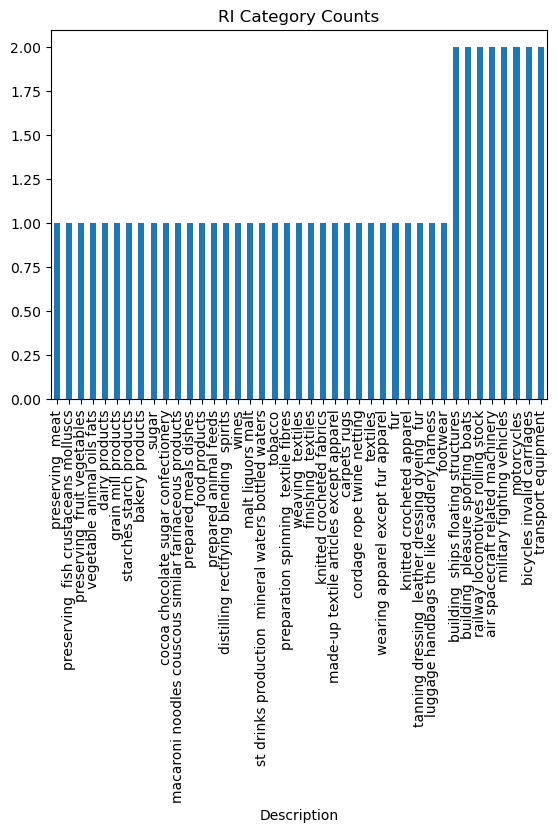

In [88]:
abruzzo_counts.plot(x='Description', y='count', kind='bar', title='RI Category Counts', legend=False)

<Axes: title={'center': 'RI Category Counts'}, xlabel='Description'>

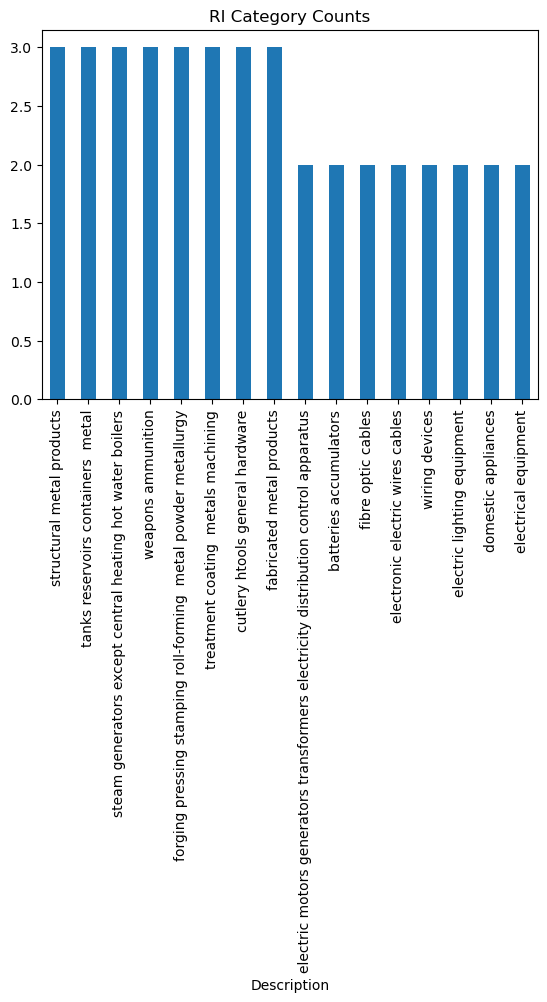

In [31]:
ri_counts.plot(x='Description', y='count', kind='bar', title='RI Category Counts', legend=False)

<Axes: title={'center': 'OR Category Counts'}, xlabel='Description'>

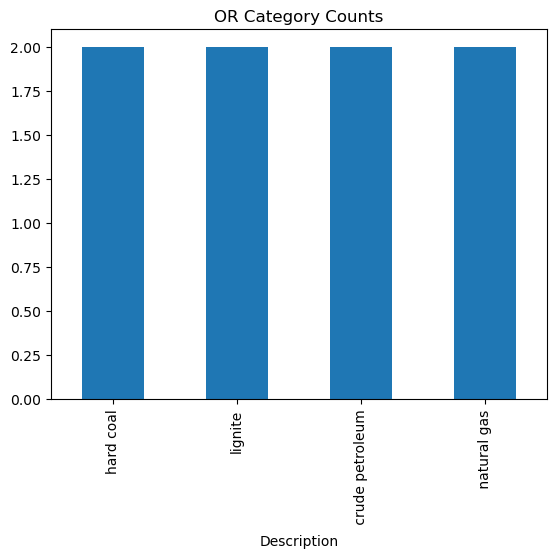

In [32]:
or_counts.plot(x='Description', y='count', kind='bar', title='OR Category Counts', legend=False)

In [33]:
## Alternatively, increment if *any* of the terms are present
alt_economy_code_counts_ri = defaultdict(int)

for key, value in codes_lookup.items():
    for sentence in economy_sentences_ri:
        for word in value[0].split():
            if word in sentence and word not in value[1].split():
                alt_economy_code_counts_ri[key] +=1
print(alt_economy_code_counts_ri)

alt_economy_code_counts_or = defaultdict(int)


for key, value in codes_lookup.items():
    for sentence in economy_sentences_or:
        for word in value[0].split():
            if word in sentence and word not in value[1].split():
                alt_economy_code_counts_or[key] +=1
print(alt_economy_code_counts_or)

# for key, value in codes_lookup.items():
#     for sentence in economy_sentences_or:
#         for word in value[0].split():
#             if any(term in sentence for term in value[0].split()) and \
#             (term not in sentence for term in value[1].split()):
#                 economy_code_counts_or[key] +=1
# print(alt_economy_code_counts_or)


defaultdict(<class 'int'>, {'D19': 2, 'D20T21': 2, 'D22': 2, 'D23': 2, 'D25': 4, 'D27': 2, 'D28': 1, 'D30': 1, 'D31T33': 5, 'D35T39': 4})
defaultdict(<class 'int'>, {'D05T06': 3, 'D17T18': 1, 'D19': 1, 'D20T21': 1, 'D22': 1, 'D23': 1, 'D25': 1, 'D26': 1, 'D29': 4, 'D35T39': 6, 'D49T53': 1})


In [34]:
# join our dataframe back to the dictionary
ri_counts_alt = pd.DataFrame(alt_economy_code_counts_ri.items(), columns=['Code', 'count'])
ri_counts_alt = ri_counts_alt.merge(codes, on='Code', how="inner")
ri_counts_alt.head()


,Code,count,Link,Class,Description,exclusion_term,Notes
0,D19,2,19,1910,coke oven products,,NaN
1,D19,2,19,1920,refined petroleum products,,NaN
2,D20T21,2,20,2011,basic chemicals,,NaN
3,D20T21,2,20,2012,fertilizers nitrogen compounds,,NaN
4,D20T21,2,20,2013,plastics synthetic rubber in primary forms,,NaN


In [35]:
or_counts_alt = pd.DataFrame(alt_economy_code_counts_or.items(), columns=['Code', 'count'])
or_counts_alt = or_counts_alt.merge(codes, on='Code', how="inner")
or_counts_alt.head()

,Code,count,Link,Class,Description,exclusion_term,Notes
0,D05T06,3,5,510,hard coal,,NaN
1,D05T06,3,5,520,lignite,,NaN
2,D05T06,3,6,610,crude petroleum,,NaN
3,D05T06,3,6,620,natural gas,,NaN
4,D17T18,1,17,1701,pulp paper paperboard,,NaN


<Axes: title={'center': 'OR Category Counts'}, xlabel='Description'>

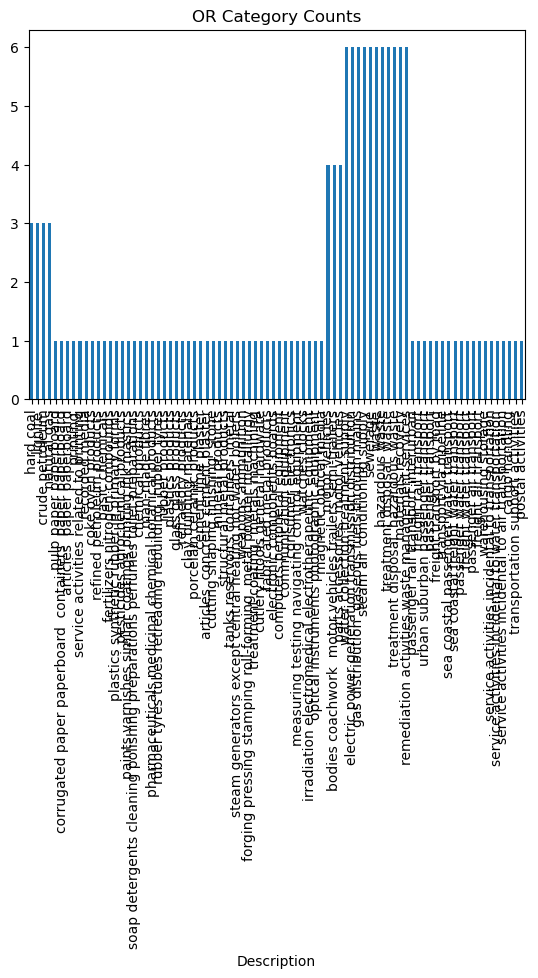

In [36]:
or_counts_alt.plot(x='Description', y='count', kind='bar', title='OR Category Counts', legend=False)

<Axes: title={'center': 'RI Category Counts'}, xlabel='Description'>

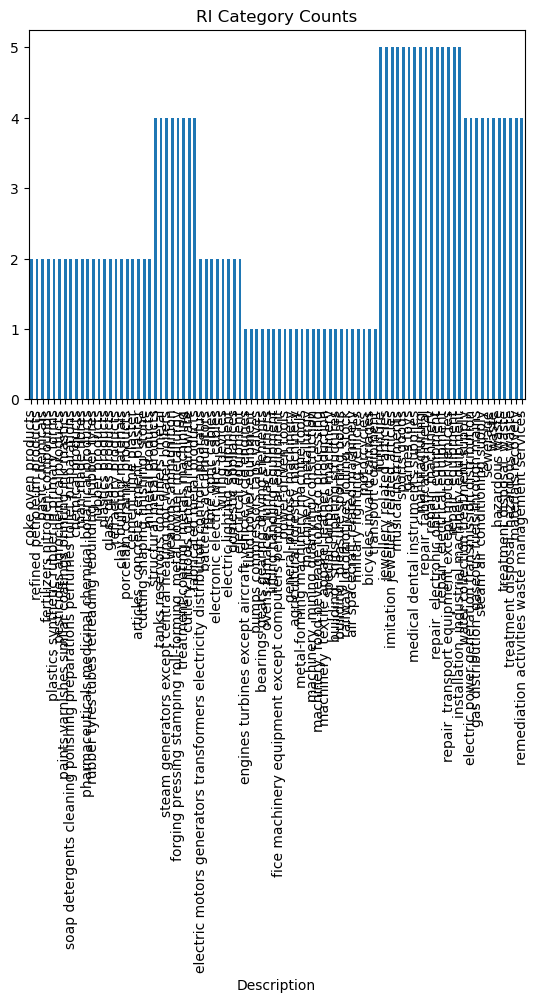

In [37]:
ri_counts_alt.plot(x='Description', y='count', kind='bar', title='RI Category Counts', legend=False)

<Axes: title={'center': 'RI Category Counts'}, xlabel='Description'>

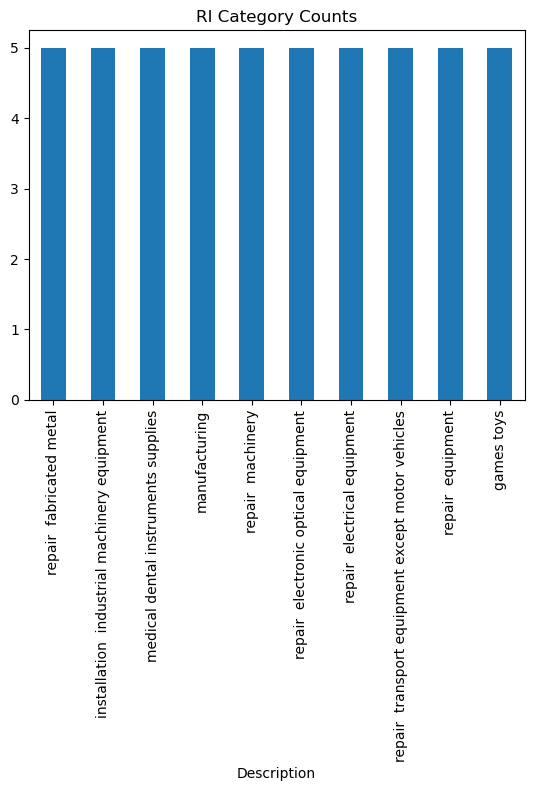

In [38]:
# plot only the top 10
ri_counts_alt.sort_values('count', ascending=False)[0:10].plot(
    x='Description', y='count', kind='bar', title='RI Category Counts', legend=False
)

<Axes: title={'center': 'RI Category Counts'}, xlabel='Description'>

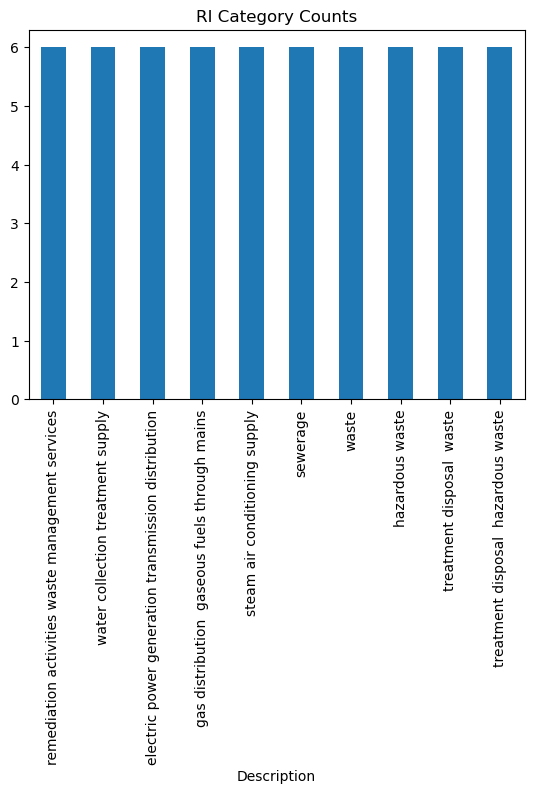

In [39]:
# plot only the top 10
or_counts_alt.sort_values('count', ascending=False)[0:10].plot(
    x='Description', y='count', kind='bar', title='RI Category Counts', legend=False
)

In [28]:
ri_counts_alt.sort_values('count', ascending=False).head(10)

,Code,count,Link,Class,Description,exclusion_term,Notes
70,D31T33,5,33,3311,repair fabricated metal,,NaN
76,D31T33,5,33,3320,installation industrial machinery equipment,,NaN
68,D31T33,5,32,3250,medical dental instruments supplies,,NaN
69,D31T33,5,32,3290,manufacturing,,removed n.e.c.
71,D31T33,5,33,3312,repair machinery,,NaN
72,D31T33,5,33,3313,repair electronic optical equipment,,NaN
73,D31T33,5,33,3314,repair electrical equipment,,NaN
74,D31T33,5,33,3315,repair transport equipment except motor vehicles,,NaN
75,D31T33,5,33,3319,repair equipment,,NaN
67,D31T33,5,32,3240,games toys,,NaN


In [29]:
or_counts_alt.sort_values('count',ascending=False).head(10)

,Code,count,Link,Class,Description,exclusion_term,Notes
62,D35T39,6,39,3900,remediation activities waste management services,,NaN
52,D35T39,6,36,3600,water collection treatment supply,,NaN
53,D35T39,6,35,3510,electric power generation transmission distrib...,,NaN
54,D35T39,6,35,3520,gas distribution gaseous fuels through mains,,NaN
55,D35T39,6,35,3530,steam air conditioning supply,,NaN
56,D35T39,6,37,3700,sewerage,,NaN
57,D35T39,6,38,3811,waste,hazardous,removed non-hazardous
58,D35T39,6,38,3812,hazardous waste,,NaN
59,D35T39,6,38,3821,treatment disposal waste,hazardous,removed non-hazardous
60,D35T39,6,38,3822,treatment disposal hazardous waste,,NaN


## Similarity Match via NLP
Jaccard similarity of sentences to terms. 

In [31]:
def jaccard_score(text1, text2):
    '''Calculate the Jaccard similarity '''
    common_terms = set(text1).intersection(set(text2))
    all_terms = set(text1).union(set(text2))
    return len(common_terms)/len(all_terms)

In [32]:
# stem the code terms
code_lookup_stems = {}
for key, value in codes_lookup.items():
    code_lookup_stems[key] = [ps.stem(x) for x in nltk.word_tokenize(value[0]) if x.lower() not in stopwords.words('english')]

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryanh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# next, remove the stop words and stem the remaining terms
# in the economic description sentences

drop_words = stopwords.words('english')

description_stems_ri = []
for sentence in economy_sentences_ri:
    description_stems_ri.append([ps.stem(x) for x in sentence.split() if x not in drop_words])

description_stems_or = []
for sentence in economy_sentences_or:
    description_stems_or.append([ps.stem(x) for x in sentence.split() if x not in drop_words])
    


description_stems_abruzzo = []
for sentence in economy_sentences_abruzzo:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_abruzzo.append([ps.stem(word)])
    

description_stems_gj = []
for sentence in economy_sentences_gj:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_gj.append([ps.stem(word)])
    
description_stems_alagoas = []
for sentence in economy_sentences_alagoas:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_alagoas.append([ps.stem(word)])
    

description_stems_ap = []
for sentence in economy_sentences_ap:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_ap.append([ps.stem(word)])
    
    
description_stems_goro = []
for sentence in economy_sentences_goro:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_goro.append([ps.stem(word)])
    
    
description_stems_eastcape = []
for sentence in economy_sentences_eastcape:
    for word in sentence.split():
        if word not in drop_words:
            description_stems_eastcape.append([ps.stem(word)])
    
    
print(len(description_stems_or))
print(len(description_stems_ri))
print(len(description_stems_abruzzo))
print(len(description_stems_gj))
print(len(description_stems_alagoas))
print(len(description_stems_ap))
print(len(description_stems_goro))
print(len(description_stems_eastcape))


print(description_stems_alagoas)


131
42
697
1635
146
421
434
287
[['economi'], ['alagoa'], ['one'], ['poorest'], ['state'], ['brazil'], ['second'], ['worst'], ['hdi'], ['countri'], ['ahead'], ['state'], ['maranhão'], ['though'], ['indic'], ['improv'], ['recent'], ['year'], ['servic'], ['sector'], ['largest'], ['compon'], ['gdp'], ['558'], ['follow'], ['industri'], ['sector'], ['369'], ['agricultur'], ['repres'], ['73'], ['state'], ['gdp'], ['2004'], ['alagoa'], ['export'], ['consist'], ['sugar'], ['588'], ['alcohol'], ['294'], ['chemic'], ['9'], ['tobacco'], ['21'], ['2002'], ['economi'], ['agricultur'], ['depend'], ['larg'], ['larg'], ['sugarcan'], ['plantat'], ['tobacco'], ['farm'], ['concentr'], ['around'], ['citi'], ['arapiraca'], ['sugar'], ['cane'], ['form'], ['basi'], ['alcohol'], ['industri'], ['declin'], ['small'], ['mediums'], ['tanker'], ['ship'], ['took'], ['alcohol'], ['board'], ['maceio'], ['port'], ['consider'], ['frequenc'], ['peak'], ['period'], ['load'], ['still'], ['take'], ['place'], ['less'], ['fr

In [51]:
print(code_lookup_stems.values())
print(len(code_lookup_stems.values()))

dict_values([['natur', 'ga'], ['mine', 'quarri'], ['tobacco'], ['footwear'], ['record', 'media'], ['refin', 'petroleum', 'product'], ['pharmaceut', 'medicin', 'chemic', 'botan', 'product'], ['plastic', 'product'], ['miner', 'product'], ['cast', 'metal'], ['fabric', 'metal', 'product'], ['magnet', 'optic', 'media'], ['electr', 'equip'], ['special-purpos', 'machineri'], ['part', 'accessori', 'motor', 'vehicl'], ['transport', 'equip'], ['instal', 'industri', 'machineri', 'equip'], ['remedi', 'activ', 'wast', 'manag', 'servic'], ['postal', 'activ']])
19


In [73]:
# iterate through the sentence stem terms
# and store the key of the higest scoring
# econ code
from collections import defaultdict

code_counts_ri = defaultdict(int)

for sentence in description_stems_ri:
    match_code = None
    score = 0.0  # Initialize score to a small value
    sentence_set = set(sentence)  # Convert the sentence list to a set
    
    for key, value in code_lookup_stems.items():
        jaccard_similarity = jaccard_score(sentence_set, value)
        if jaccard_similarity > score:
            match_code = key
            score = jaccard_similarity
    
    if match_code:
        code_counts_ri[match_code] += 1


print(code_counts_ri)

defaultdict(<class 'int'>, {'D31T33': 5, 'D29': 1, 'D35T39': 2, 'D22': 3, 'D25': 1, 'D27': 1})


In [77]:
from collections import defaultdict
code_counts_abruzzo = defaultdict(int)


for sentence in description_stems_abruzzo:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        count = code_counts_abruzzo[match_code]
        code_counts_abruzzo[match_code] = count + 1

print(code_counts_abruzzo)

defaultdict(<class 'int'>, {2826: 3, 2824: 1, 3830: 1, 1820: 1, 5229: 2, 5223: 1, 3320: 3, 3313: 1, 5310: 1, 1102: 1, 3520: 1, 620: 2, 3230: 1, 5012: 1, 1104: 1})


In [42]:
code_counts_or = defaultdict(int)
for sentence in description_stems_or:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_or[match_code] += 1
code_counts_or

code_counts_abruzzo = defaultdict(int)

for sentence in description_stems_abruzzo:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_abruzzo[match_code] += 1
        

code_counts_gj = defaultdict(int)

for sentence in description_stems_gj:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_gj[match_code] += 1
        

        
code_counts_alagoas = defaultdict(int)

for sentence in description_stems_alagoas:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_alagoas[match_code] += 1
        
print(code_counts_alagoas)
code_counts_ap = defaultdict(int)

for sentence in description_stems_ap:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        count = code_counts_ap[match_code]
        code_counts_ap[match_code] = count + 1


        

code_counts_goro = defaultdict(int)

for sentence in description_stems_goro:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_goro[match_code] += 1
        


code_counts_eastcape = defaultdict(int)

for sentence in description_stems_eastcape:
    match_code = None
    score = 0
    for key, value in code_lookup_stems.items():
        if jaccard_score(sentence, value) > score:
            match_code = key
    if match_code:
        code_counts_eastcape[match_code] += 1
        
print(code_counts_eastcape)

defaultdict(<class 'int'>, {5223: 1, 2610: 2, 3320: 4, 2821: 2, 1073: 2, 2100: 2, 2825: 2, 2013: 2, 3011: 1, 2826: 1, 2813: 1, 2012: 1})
defaultdict(<class 'int'>, {2821: 3, 3320: 8, 5222: 1, 2012: 2, 1030: 1, 1050: 1, 2826: 2, 2013: 1, 2750: 1, 3020: 1, 3240: 3, 620: 2, 2814: 1, 1020: 4, 3600: 1, 3520: 1, 4923: 1, 4912: 1, 3510: 1, 3315: 1, 2824: 1, 3011: 1, 5223: 1})


(48, 7)
      Code  count  Link  Class  \
0   D31T33      5    31   3100   
1   D31T33      5    32   3211   
2   D31T33      5    32   3212   
3   D31T33      5    32   3220   
4   D31T33      5    32   3230   
5   D31T33      5    32   3240   
6   D31T33      5    32   3250   
7   D31T33      5    32   3290   
8   D31T33      5    33   3311   
9   D31T33      5    33   3312   
10  D31T33      5    33   3313   
11  D31T33      5    33   3314   
12  D31T33      5    33   3315   
13  D31T33      5    33   3319   
14  D31T33      5    33   3320   
15     D29      1    29   2910   
16     D29      1    29   2920   
17     D29      1    29   2930   
18  D35T39      2    36   3600   
19  D35T39      2    35   3510   
20  D35T39      2    35   3520   
21  D35T39      2    35   3530   
22  D35T39      2    37   3700   
23  D35T39      2    38   3811   
24  D35T39      2    38   3812   
25  D35T39      2    38   3821   
26  D35T39      2    38   3822   
27  D35T39      2    38   3830   
28  D3

<AxesSubplot: title={'center': 'RI Category Counts'}, xlabel='Description'>

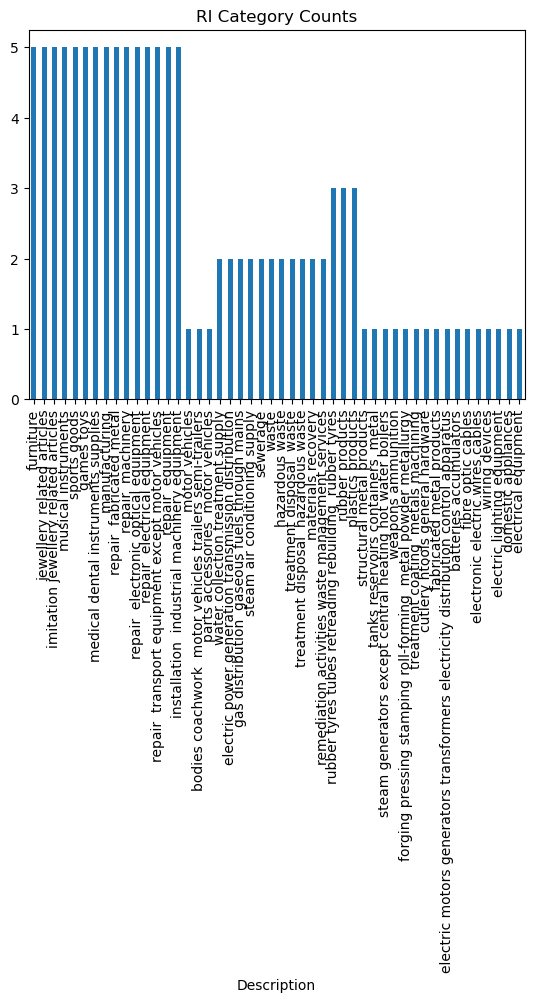

In [41]:
ri_matches = pd.DataFrame(code_counts_ri.items(), columns = ['Code','count'])
ri_matches = ri_matches.merge(codes, on='Code', how='left')
print(ri_matches.shape)
ri_matches.sort_values('count', ascending=False).head(10)

print(ri_matches)
ri_matches.plot(x='Description', y='count', kind='bar', title='RI Category Counts', legend=False)

In [48]:
or_matches = pd.DataFrame(code_counts_or.items(), columns = ['Code','count'])
or_matches = or_matches.merge(codes, on='Code', how='left')
print(or_matches.shape)
or_matches.sort_values('count', ascending=False).head(10)

(68, 7)


,Code,count,Link,Class,Description,exclusion_term,Notes
26,D31T33,11,32,3290,manufacturing,,removed n.e.c.
25,D31T33,11,32,3250,medical dental instruments supplies,,NaN
33,D31T33,11,33,3320,installation industrial machinery equipment,,NaN
32,D31T33,11,33,3319,repair equipment,,NaN
31,D31T33,11,33,3315,repair transport equipment except motor vehicles,,NaN
30,D31T33,11,33,3314,repair electrical equipment,,NaN
29,D31T33,11,33,3313,repair electronic optical equipment,,NaN
24,D31T33,11,32,3240,games toys,,NaN
23,D31T33,11,32,3230,sports goods,,NaN
22,D31T33,11,32,3220,musical instruments,,NaN


(26, 7)
    Class  count    Code  Link  \
0    2826      9     D28    28   
1    2824      1     D28    28   
2    3830      1  D35T39    38   
3    1820      1  D17T18    18   
4    3320     12  D31T33    33   
5    2811      1     D28    28   
6    5229      2  D49T53    52   
7    3011      1     D30    30   
8    2710      1     D27    27   
9    2821      3     D28    28   
10   5223      1  D49T53    52   
11   2100      1  D20T21    21   
12   3313      1  D31T33    33   
13   1520      1  D13T15    15   
14   1073      2  D10T12    10   
15   5310      1  D49T53    53   
16   1102      5  D10T12    11   
17   1040      4  D10T12    10   
18   1030      2  D10T12    10   
19   1050      1  D10T12    10   
20   3520      1  D35T39    35   
21   2825      1     D28    28   
22    620      4  D05T06     6   
23   3230      1  D31T33    32   
24   5012      1  D49T53    50   
25   1104      1  D10T12    11   

                                          Description exclusion_term Note

<AxesSubplot: title={'center': 'abruzzo Category Counts'}, xlabel='Description'>

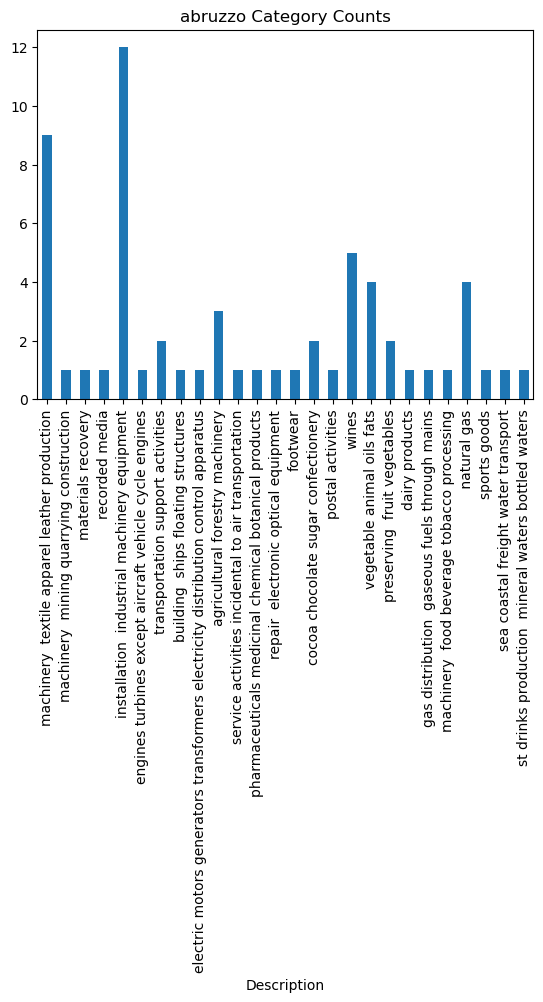

In [58]:
abruzzo_matches = pd.DataFrame(code_counts_abruzzo.items(), columns=['Class', 'count'])
abruzzo_matches = abruzzo_matches.merge(codes, on='Class', how='left')

# Sorting and displaying the top 10 matches
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(abruzzo_matches.shape)
print(abruzzo_matches)
# Plotting the counts
abruzzo_matches.plot(x='Description', y='count', kind='bar', title='abruzzo Category Counts', legend=False)

(62, 7)
    Class  count    Code  Link  \
0    3020      1     D30    30   
1    3320      9  D31T33    33   
2    2513      2     D25    25   
3    3290      3  D31T33    32   
4    2821      9     D28    28   
5    1020      5  D10T12    10   
6    5310      7  D49T53    53   
7    5223      3  D49T53    52   
8    5229      4  D49T53    52   
9    5210      1  D49T53    52   
10   2824     17     D28    28   
11   2826      6     D28    28   
12   2930      4     D29    29   
13   2100      1  D20T21    21   
14   2825      3     D28    28   
15   3230      2  D31T33    32   
16   1040      1  D10T12    10   
17   1920      1     D19    19   
18   3830      1  D35T39    38   
19   4930      1  D49T53    49   
20   3315      3  D31T33    33   
21   3012      1     D30    30   
22   3510      1  D35T39    35   
23   2013      3  D20T21    20   
24   2310      3     D23    23   
25   2431      2     D24    24   
26   2393      4     D23    23   
27   3212      2  D31T33    32   
28   2

<AxesSubplot: title={'center': 'GJ Category Counts'}, xlabel='Description'>

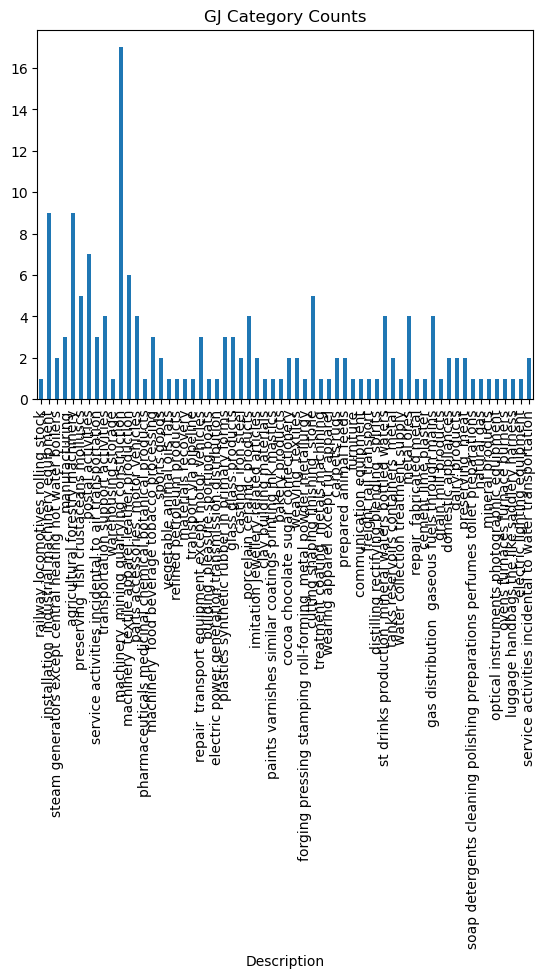

In [48]:
gj_matches = pd.DataFrame(code_counts_gj.items(), columns = ['Class','count'])
gj_matches = gj_matches.merge(codes, on='Class', how='left')
print(gj_matches.shape)
gj_matches.sort_values('count', ascending=False).head(10)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(gj_matches)
gj_matches.plot(x='Description', y='count', kind='bar', title='GJ Category Counts', legend=False)

(12, 7)
    Class  count    Code  Link  \
0    5223      1  D49T53    52   
1    2610      2     D26    26   
2    3320      4  D31T33    33   
3    2821      2     D28    28   
4    1073      2  D10T12    10   
5    2100      2  D20T21    21   
6    2825      2     D28    28   
7    2013      2  D20T21    20   
8    3011      1     D30    30   
9    2826      1     D28    28   
10   2813      1     D28    28   
11   2012      1  D20T21    20   

                                          Description exclusion_term Notes  
0   service activities incidental to air transport...                  NaN  
1                        electronic components boards                  NaN  
2        installation  industrial machinery equipment                  NaN  
3                     agricultural forestry machinery                  NaN  
4                 cocoa chocolate sugar confectionery                  NaN  
5   pharmaceuticals medicinal chemical botanical p...                  NaN  
6         

<AxesSubplot: title={'center': 'Alagoas Category Counts'}, xlabel='Description'>

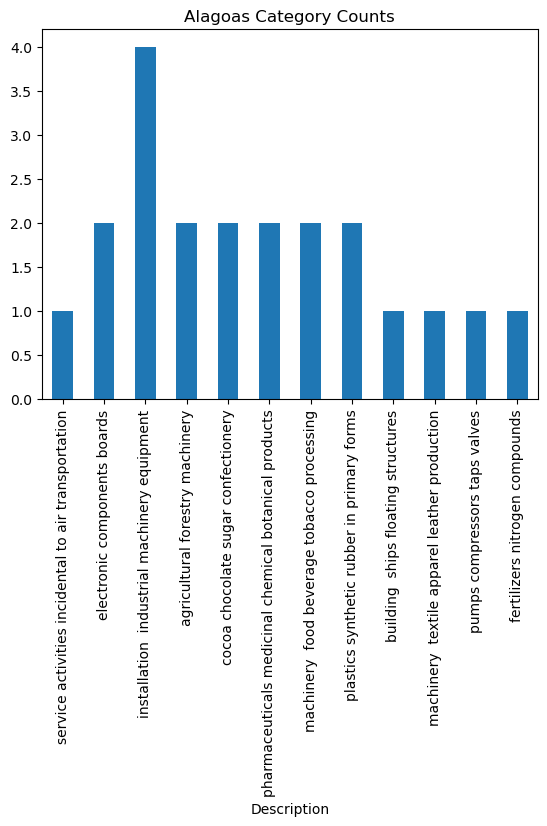

In [39]:
alagoas_matches = pd.DataFrame(code_counts_alagoas.items(), columns = ['Class','count'])
alagoas_matches = alagoas_matches.merge(codes, on='Class', how='left')
print(alagoas_matches.shape)
alagoas_matches.sort_values('count', ascending=False).head(10)


print(alagoas_matches)
alagoas_matches.plot(x='Description', y='count', kind='bar', title='Alagoas Category Counts', legend=False)

(23, 7)
    Class  count    Code  Link  \
0    2821      6     D28    28   
1    3320      5  D31T33    33   
2    5223      2  D49T53    52   
3    1820      2  D17T18    18   
4    5222      1  D49T53    52   
5    3212      1  D31T33    32   
6    5310      1  D49T53    53   
7    2825      5     D28    28   
8    1701      1  D17T18    17   
9    1040      6  D10T12    10   
10   2826      9     D28    28   
11   1020      3  D10T12    10   
12   3290      2  D31T33    32   
13   3315      4  D31T33    33   
14   2399      4     D23    23   
15   2100      2  D20T21    21   
16   3011      1     D30    30   
17   3830      1  D35T39    38   
18   3520      3  D35T39    35   
19   2824      1     D28    28   
20    610      2  D05T06     6   
21    620      2  D05T06     6   
22   2750      3     D27    27   

                                          Description exclusion_term  \
0                     agricultural forestry machinery                  
1        installation  industri

<AxesSubplot: title={'center': 'AP Category Counts'}, xlabel='Description'>

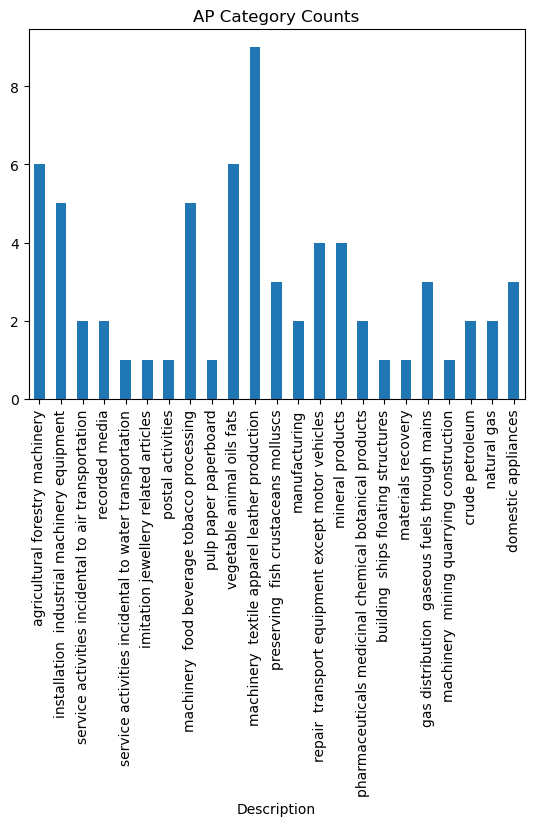

In [57]:
ap_matches = pd.DataFrame(code_counts_ap.items(), columns = ['Class','count'])
ap_matches = ap_matches.merge(codes, on='Class', how='left')
print(ap_matches.shape)
ap_matches.sort_values('count', ascending=False).head(10)


print(ap_matches)
ap_matches.plot(x='Description', y='count', kind='bar', title='AP Category Counts', legend=False)

(16, 7)
    Class  count    Code  Link  \
0    3011      1     D30    30   
1    2814      2     D28    28   
2    2821      7     D28    28   
3    5223      1  D49T53    52   
4    3520      2  D35T39    35   
5    3012      1     D30    30   
6    1020      1  D10T12    10   
7    3320      1  D31T33    33   
8    2826     18     D28    28   
9    2420      1     D24    24   
10   2825      4     D28    28   
11   2630      1     D26    26   
12    620      2  D05T06     6   
13   1040      2  D10T12    10   
14   2824      1     D28    28   
15   5012      3  D49T53    50   

                                          Description exclusion_term  \
0                 building  ships floating structures                  
1             bearings gears gearing driving elements                  
2                     agricultural forestry machinery                  
3   service activities incidental to air transport...                  
4       gas distribution  gaseous fuels through mains

<AxesSubplot: title={'center': 'goro Category Counts'}, xlabel='Description'>

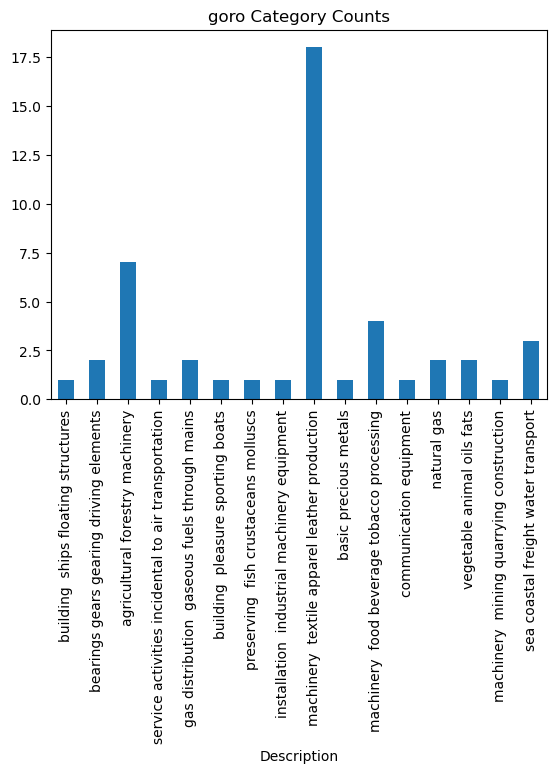

In [38]:
goro_matches = pd.DataFrame(code_counts_goro.items(), columns = ['Class','count'])
goro_matches = goro_matches.merge(codes, on='Class', how='left')
print(goro_matches.shape)
goro_matches.sort_values('count', ascending=False).head(10)


print(goro_matches)
goro_matches.plot(x='Description', y='count', kind='bar', title='goro Category Counts', legend=False)

(23, 7)
    Class  count    Code  Link  \
0    2821      3     D28    28   
1    3320      8  D31T33    33   
2    5222      1  D49T53    52   
3    2012      2  D20T21    20   
4    1030      1  D10T12    10   
5    1050      1  D10T12    10   
6    2826      2     D28    28   
7    2013      1  D20T21    20   
8    2750      1     D27    27   
9    3020      1     D30    30   
10   3240      3  D31T33    32   
11    620      2  D05T06     6   
12   2814      1     D28    28   
13   1020      4  D10T12    10   
14   3600      1  D35T39    36   
15   3520      1  D35T39    35   
16   4923      1  D49T53    49   
17   4912      1  D49T53    49   
18   3510      1  D35T39    35   
19   3315      1  D31T33    33   
20   2824      1     D28    28   
21   3011      1     D30    30   
22   5223      1  D49T53    52   

                                          Description exclusion_term Notes  
0                     agricultural forestry machinery                  NaN  
1        installation

<AxesSubplot: title={'center': 'eastcape Category Counts'}, xlabel='Description'>

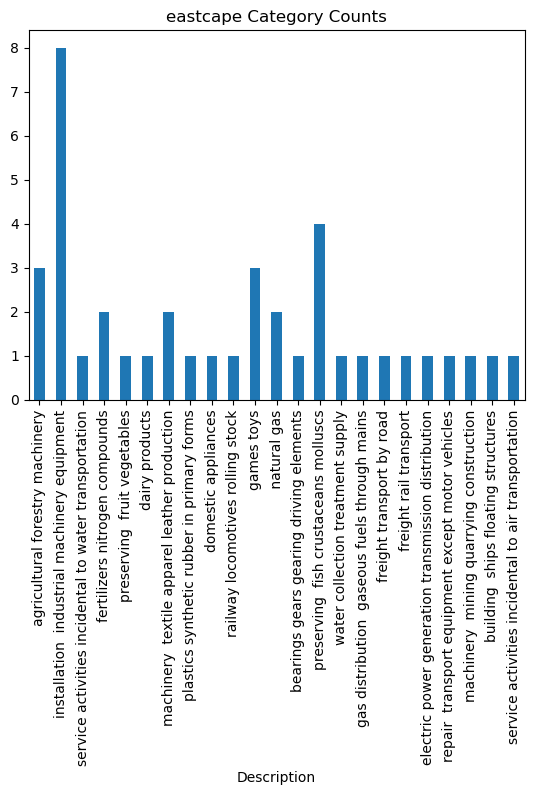

In [43]:
eastcape_matches = pd.DataFrame(code_counts_eastcape.items(), columns = ['Class','count'])
eastcape_matches = eastcape_matches.merge(codes, on='Class', how='left')
print(eastcape_matches.shape)
eastcape_matches.sort_values('count', ascending=False).head(10)


print(eastcape_matches)
eastcape_matches.plot(x='Description', y='count', kind='bar', title='eastcape Category Counts', legend=False)

In [51]:
# remove dupes from NAICS codes
# note that some are because of excluded terms,
# those should not be removed! 
na_codes = pd.read_csv('2022_NAICS_Codes_all_levels_edited.csv')
print(na_codes.shape)
na_codes.head()

(2125, 5)


,sequence,NAICS_Code_2022,NAICS_Title_2022,NAICS_search,excluded_terms
0,1,11,"Agriculture, Forestry, Fishing and Hunting",agriculture forestry fishing hunting,NaN
1,2,111,Crop Production,crop production,NaN
2,3,1111,Oilseed and Grain Farming,oilseed grain farming,NaN
3,4,11111,Soybean Farming,soybean farming,NaN
4,5,111110,Soybean Farming,soybean farming,NaN


In [52]:
test = na_codes.groupby(['NAICS_search','excluded_terms'])
len(test)

1561

In [53]:
test.head()

,sequence,NAICS_Code_2022,NAICS_Title_2022,NAICS_search,excluded_terms
5,6,11112,Oilseed (except Soybean) Farming,oilseed farming,soybean
6,7,111120,Oilseed (except Soybean) Farming,oilseed farming,soybean
21,22,111219,Other Vegetable (except Potato) and Melon Farm...,other vegetable melon farming,potato
25,26,11132,Citrus (except Orange) Groves,citrus groves,orange
26,27,111320,Citrus (except Orange) Groves,citrus groves,orange
...,...,...,...,...,...
2012,2013,812921,Photofinishing Laboratories (except One-Hour),photofinishing laboratories,one-hour
2044,2045,81399,"Other Similar Organizations (except Business, ...",other similar organizations,business professional labor political organiza...
2045,2046,813990,"Other Similar Organizations (except Business, ...",other similar organizations,business professional labor political organiza...
2087,2088,92313,Administration of Human Resource Programs (exc...,administration of human resource programs,education public health veterans' affairs prog...
